In [102]:
import numpy as np
import scanpy as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
import gseapy

from ete3 import Tree

import pickle as pic

import diffxpy.api as de 

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook

import utilities.de_utils as de_utils

np.set_printoptions(threshold=np.nan)

## Read in and process data

In [103]:
path = "/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

meta = pd.read_csv("data/5k.LG_meta.txt", sep='\t', index_col=0)
latent = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

gene_list = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values

adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (40969, 7))

In [104]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['nUMI'] = adata.X.sum(axis=1).A1
adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1

adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")

# meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
# adata = adata[meta_filter,:]

In [105]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [106]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

In [107]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [108]:
sc.pp.log1p(adata)

/home/mattjones/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Perform DE analyses 

### First compare highly metastatic clones to lowly

In [111]:
adata_met = de_utils.filter_data_continuous(adata, 'StaticMetScore', 0.60)

perc = np.percentile(adata_met.obs['DynamicMetScore'], 50)
adata_met = de_utils.split_data_continuous(adata_met, 'DynamicMetScore', perc)
sc.tl.rank_genes_groups(adata_met, "Groupby", groups=["High"], reference="BG", method="wilcoxon", n_genes = 7000, only_positive = False)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'Groupby' as categorical
... storing 'condition' as categorical
... storing 'gene_ids' as categorical


In [112]:
result = adata_met.uns["rank_genes_groups"]
groups = result['names'].dtype.names

met_de = de_utils.create_DE_df(adata_met, "Groupby", "High", "BG", result)
met_de.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/high_met_de.txt", sep='\t')
met_de = met_de[met_de['qval'] < 0.05]

unique_genes = de_utils.consolidate_genes([met_de])

met_de_bulk = de_utils.bulk_by_group(adata_met.obs['Groupby'], adata_met, unique_genes)

(28562, 4005) 28562 [ True  True False  True False False False False False  True]


100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


### LL only samples

In [70]:
adata_ll = de_utils.filter_data_discrete(adata, 'sampleID', ["LL"])
ll_groups = [29, 46, 78, 94]
adata_ll = de_utils.split_data_discrete(adata_ll, 'LineageGroup', ll_groups)

sc.tl.rank_genes_groups(adata_ll, "Groupby", groups=ll_groups, reference="BG", method="wilcoxon", n_genes = 7000, only_positive = False)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sampleID' as categorical
... storing 'Sample2' as categorical
... storing 'Groupby' as categorical
... storing 'condition' as categorical
... storing 'gene_ids' as categorical


In [89]:
result = adata_ll.uns["rank_genes_groups"]
groups = result['names'].dtype.names

lg29_ll = de_utils.create_DE_df(adata_ll, "Groupby", "29", "BG", result)
lg36_ll = de_utils.create_DE_df(adata_ll, "Groupby", "46", "BG", result)
lg78_ll = de_utils.create_DE_df(adata_ll, "Groupby", "78", "BG", result)
lg94_ll = de_utils.create_DE_df(adata_ll, "Groupby", "94", "BG", result)

lg29_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg29_ll.txt", sep='\t')
lg36_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg36_ll.txt", sep='\t')
lg78_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg78_ll.txt", sep='\t')
lg94_ll.to_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/lg94_ll.txt", sep='\t')

lg29_ll = lg29_ll[lg29_ll['qval'] < 0.05]
lg36_ll = lg36_ll[lg36_ll['qval'] < 0.05]
lg78_ll = lg78_ll[lg78_ll['qval'] < 0.05]
lg94_ll = lg94_ll[lg94_ll['qval'] < 0.05]


unique_genes = de_utils.consolidate_genes([lg29_ll, lg36_ll, lg78_ll, lg94_ll])

ll_de_bulk = de_utils.bulk_by_group(adata_ll.obs['Groupby'], adata_ll, unique_genes)

(1995, 4005) 1995 [False False False  True False False False False False False]
(1995, 4005) 1995 [ True False False False False False False False False False]
(1995, 4005) 1995 [False False False False False False False False False False]
(1995, 4005) 1995 [False False False False False False False False False False]


100%|██████████| 5/5 [00:00<00:00, 35.66it/s]


<Figure size 1008x720 with 0 Axes>

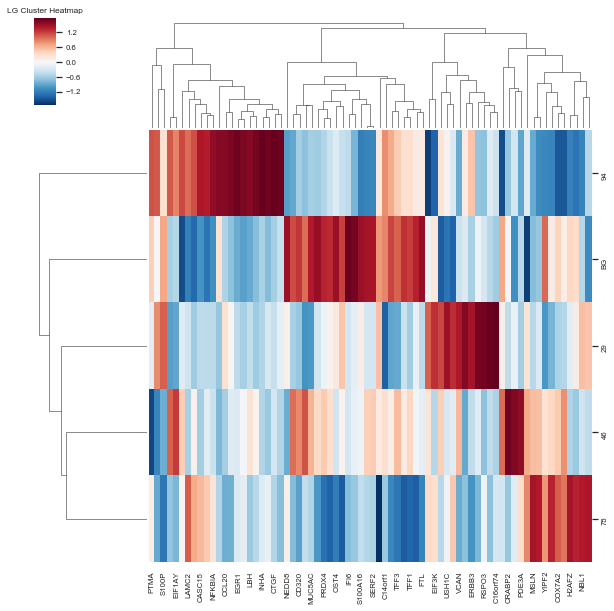

In [90]:
sns.set(font_scale=0.7)
plt.figure(figsize=(14, 10))
hm = sns.clustermap(ll_de_bulk, cmap="RdBu_r", z_score=1, fmt='d')
plt.title("LG Cluster Heatmap")
plt.savefig("figs/5k_ll_clusterheatmap.pdf")
plt.show()